In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import scipy as sc

In [2]:
img_size=(240, 320)
img_channels = 3
batch_size=32
epochs = 50
display_epochs = (0, 100)


In [3]:
model_name = 'depthwise_(32-64-126)3_(NaN).tf'

In [4]:
train_size = 1000
validation_size = 500
test_size = 500

# Load the DataSet

Dataset citation:
- From Semi-Supervised to Transfer Counting of Crowds
C. C. Loy, S. Gong, and T. Xiang
in Proceedings of IEEE International Conference on Computer Vision, pp. 2256-2263, 2013 (ICCV)
- Cumulative Attribute Space for Age and Crowd Density Estimation
K. Chen, S. Gong, T. Xiang, and C. C. Loy
in Proceedings of IEEE Conference on Computer Vision and Pattern Recognition, pp. 2467-2474, 2013 (CVPR, Oral)
- Crowd Counting and Profiling: Methodology and Evaluation
C. C. Loy, K. Chen, S. Gong, T. Xiang
in S. Ali, K. Nishino, D. Manocha, and M. Shah (Eds.), Modeling, Simulation and Visual Analysis of Crowds, Springer, vol. 11, pp. 347-382, 2013
- Feature Mining for Localised Crowd Counting
K. Chen, C. C. Loy, S. Gong, and T. Xiang
British Machine Vision Conference, 2012 (BMVC)

In [5]:
dataset_path = '/Users/olove/Library/CloudStorage/OneDrive-Personal/AI datasets/CrowdCounter'

In [6]:
labels_df = pd.read_csv(dataset_path + '/labels.csv')
labels_df['image_name'] = labels_df['id'].map('seq_{:06d}.jpg'.format)
labels_df.drop("id", axis=1,inplace=True)
display(labels_df)

,count,image_name
0,35,seq_000001.jpg
1,41,seq_000002.jpg
2,41,seq_000003.jpg
3,44,seq_000004.jpg
4,41,seq_000005.jpg
...,...,...
1995,27,seq_001996.jpg
1996,27,seq_001997.jpg
1997,25,seq_001998.jpg
1998,26,seq_001999.jpg


In [7]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)
display(labels_df)

,count,image_name
0,31,seq_000297.jpg
1,40,seq_001712.jpg
2,32,seq_001590.jpg
3,32,seq_000967.jpg
4,41,seq_000139.jpg
...,...,...
1995,28,seq_000191.jpg
1996,23,seq_000024.jpg
1997,30,seq_001230.jpg
1998,37,seq_000359.jpg


In [8]:
if (train_size+validation_size+test_size) != len(labels_df):
    print('Dataset size is different from specified class sizes')
    exit(1)

training_df = labels_df[:train_size]
validation_df = labels_df[train_size:train_size+validation_size].reset_index(drop=True)
test_df = labels_df[train_size+validation_size:].reset_index(drop=True)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    
)

x_col_name = 'image_name'
y_col_name = 'count'

train_generator = datagen.flow_from_dataframe(
    training_df, 
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

validation_generator = datagen.flow_from_dataframe(
    validation_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    dataset_path + '/frames/frames/',
    x_col=x_col_name,
    y_col=y_col_name,
    class_mode='raw',
    target_size=img_size,
    batch_size=batch_size,
)

Found 1000 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


# Define the model

In [10]:
inputs = keras.Input(shape= img_size + (img_channels,))

## Custom Simple Covnet

Downsizing using strides instead of MaxPolling in order to conserve location data

In [11]:
def basic_covnet_block(input):
    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
    return x

## Custom Depthwise Seperable Convolution

In [12]:
def custom_depthwise_conv_block(input, sizes, repeat_per_size, stride = 1, pooling = False, dropout = False):
    x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(input)
    
    for size in sizes:
        for i in range(repeat_per_size - 1):
            x = layers.BatchNormalization()(x)
            x  = layers.Activation("relu")(x)
            x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x  = layers.Activation("relu")(x)
        if dropout:
            x = layers.Dropout(0.5)(x)
        x = layers.SeparableConv2D(size, 3, stride, padding='same', use_bias=False)(x)
        if pooling:
            x = layers.MaxPooling2D()(x)
        
    return x
        

# Output Layer

In [13]:
def basic_dense_block(covnet_param, sizes):
    x = layers.Flatten()(covnet_param)
    for size in sizes:
        x = layers.Dense(size, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return outputs

In [14]:
covnet = custom_depthwise_conv_block(inputs, [32, 64, 128, 256], 3, stride=2)
outputs = basic_dense_block(covnet, [])
model = keras.Model(inputs=inputs, outputs=outputs)

2023-12-14 11:28:52.754072: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-14 11:28:52.754107: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-14 11:28:52.754114: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-14 11:28:52.754191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 11:28:52.754473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 236, 316, 32)      2400      
                                                                 
 batch_normalization (Batch  (None, 236, 316, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 236, 316, 32)      0         
                                                                 
 separable_conv2d (Separabl  (None, 236, 316, 32)      1312      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 236, 316, 32)      128   

# Train model

In [16]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
# TODO: Try mae vs accuracy. mae should be better since we are adjusting it to get closer to the actual value

In [17]:
callbacks_list = [
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss", patience=4
#    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        monitor="val_loss",
        save_best_only=True
    ),
    keras.callbacks.TensorBoard()
]

In [18]:
Wsave = model.get_weights()

In [19]:
model.set_weights(Wsave)
history = model.fit(train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
)

Epoch 1/50


2023-12-14 11:28:54.069544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 103.2134 - mae: 7.0847INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 23s 641ms/step - loss: 103.2134 - mae: 7.0847 - val_loss: 1001.2879 - val_mae: 30.9318
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 17.8477 - mae: 3.3339INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 23s 656ms/step - loss: 17.8477 - mae: 3.3339 - val_loss: 997.6563 - val_mae: 30.8731
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 8.7810 - mae: 2.3037INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 656ms/step - loss: 8.7810 - mae: 2.3037 - val_loss: 994.6826 - val_mae: 30.8248
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 5.3886 - mae: 1.8299INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 642ms/step - loss: 5.3886 - mae: 1.8299 - val_loss: 989.4777 - val_mae: 30.7403
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 5.4444 - mae: 1.8318INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 20s 635ms/step - loss: 5.4444 - mae: 1.8318 - val_loss: 982.7941 - val_mae: 30.6314
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 5.5104 - mae: 1.9207INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 642ms/step - loss: 5.5104 - mae: 1.9207 - val_loss: 981.2474 - val_mae: 30.6061
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 3.6746 - mae: 1.5362INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 22s 651ms/step - loss: 3.6746 - mae: 1.5362 - val_loss: 979.6373 - val_mae: 30.5798
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 2.2004 - mae: 1.1744INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 20s 626ms/step - loss: 2.2004 - mae: 1.1744 - val_loss: 979.1481 - val_mae: 30.5719
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 2.9843 - mae: 1.3957INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 668ms/step - loss: 2.9843 - mae: 1.3957 - val_loss: 975.3823 - val_mae: 30.5103
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 4.2071 - mae: 1.7039INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 631ms/step - loss: 4.2071 - mae: 1.7039 - val_loss: 970.0640 - val_mae: 30.4231
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.7085 - mae: 1.0469INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 20s 619ms/step - loss: 1.7085 - mae: 1.0469 - val_loss: 963.0733 - val_mae: 30.3082
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.4988 - mae: 0.9747INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 23s 726ms/step - loss: 1.4988 - mae: 0.9747 - val_loss: 961.4421 - val_mae: 30.2818
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.6250 - mae: 1.0045INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 23s 680ms/step - loss: 1.6250 - mae: 1.0045 - val_loss: 953.3823 - val_mae: 30.1499
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 0.8553 - mae: 0.7234INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 643ms/step - loss: 0.8553 - mae: 0.7234 - val_loss: 938.2282 - val_mae: 29.9022
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 0.9033 - mae: 0.7603INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 672ms/step - loss: 0.9033 - mae: 0.7603 - val_loss: 908.4000 - val_mae: 29.4128
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 0.8662 - mae: 0.7429INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 668ms/step - loss: 0.8662 - mae: 0.7429 - val_loss: 835.9235 - val_mae: 28.1927
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 0.7832 - mae: 0.6988INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 655ms/step - loss: 0.7832 - mae: 0.6988 - val_loss: 724.9585 - val_mae: 26.2300
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 1.2477 - mae: 0.9162INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 662ms/step - loss: 1.2477 - mae: 0.9162 - val_loss: 575.3998 - val_mae: 23.3414
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 0.8159 - mae: 0.7337INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 22s 653ms/step - loss: 0.8159 - mae: 0.7337 - val_loss: 453.0191 - val_mae: 20.6598
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.7067 - mae: 0.6700INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 20s 619ms/step - loss: 0.7067 - mae: 0.6700 - val_loss: 323.6476 - val_mae: 17.4155
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.7761 - mae: 1.0520INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 646ms/step - loss: 1.7761 - mae: 1.0520 - val_loss: 154.1433 - val_mae: 11.8338
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.7369 - mae: 1.0285INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 643ms/step - loss: 1.7369 - mae: 1.0285 - val_loss: 120.2323 - val_mae: 10.4428
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 1.0826 - mae: 0.8045INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 20s 618ms/step - loss: 1.0826 - mae: 0.8045 - val_loss: 38.9171 - val_mae: 5.4805
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.8983 - mae: 0.7694INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 643ms/step - loss: 0.8983 - mae: 0.7694 - val_loss: 10.9302 - val_mae: 2.6710
Epoch 25/50
32/32 [==============================] - 19s 596ms/step - loss: 0.6097 - mae: 0.6233 - val_loss: 32.8751 - val_mae: 5.1088
Epoch 26/50
32/32 [==============================] - 19s 593ms/step - loss: 0.5273 - mae: 0.5698 - val_loss: 20.2684 - val_mae: 3.8258
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.5966 - mae: 0.6087INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 20s 631ms/step - loss: 0.5966 - mae: 0.6087 - val_loss: 6.7503 - val_mae: 2.0435
Epoch 28/50
32/32 [==============================] - 18s 571ms/step - loss: 0.3473 - mae: 0.4590 - val_loss: 7.4369 - val_mae: 2.1545
Epoch 29/50
32/32 [==============================] - 19s 601ms/step - loss: 0.4335 - mae: 0.5116 - val_loss: 8.1896 - val_mae: 2.2853
Epoch 30/50
32/32 [==============================] - 19s 594ms/step - loss: 0.5617 - mae: 0.5719 - val_loss: 8.0541 - val_mae: 2.2615
Epoch 31/50
32/32 [==============================] - 19s 595ms/step - loss: 0.5564 - mae: 0.5875 - val_loss: 8.5379 - val_mae: 2.3317
Epoch 32/50
32/32 [==============================] - 20s 614ms/step - loss: 0.6769 - mae: 0.6542 - val_loss: 18.5690 - val_mae: 3.6778
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.8396 - mae: 0.7042INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 667ms/step - loss: 0.8396 - mae: 0.7042 - val_loss: 5.8389 - val_mae: 1.9234
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.4682 - mae: 0.5272INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 21s 656ms/step - loss: 0.4682 - mae: 0.5272 - val_loss: 5.4186 - val_mae: 1.8159
Epoch 35/50
32/32 [==============================] - 19s 590ms/step - loss: 0.9168 - mae: 0.7929 - val_loss: 35.6157 - val_mae: 5.5080
Epoch 36/50
32/32 [==============================] - 19s 585ms/step - loss: 1.9398 - mae: 1.1548 - val_loss: 6.4643 - val_mae: 2.0218
Epoch 37/50
32/32 [==============================] - 19s 593ms/step - loss: 1.0167 - mae: 0.7957 - val_loss: 8.0883 - val_mae: 2.2719
Epoch 38/50
32/32 [==============================] - 20s 620ms/step - loss: 0.6447 - mae: 0.6254 - val_loss: 5.8811 - val_mae: 1.9086
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.6036 - mae: 0.6289INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


INFO:tensorflow:Assets written to: depthwise_(32-64-126)3_(NaN).tf/assets


32/32 [==============================] - 24s 717ms/step - loss: 0.6036 - mae: 0.6289 - val_loss: 5.1446 - val_mae: 1.7773
Epoch 40/50
32/32 [==============================] - 23s 658ms/step - loss: 0.5017 - mae: 0.5642 - val_loss: 6.9928 - val_mae: 2.0853
Epoch 41/50
32/32 [==============================] - 20s 626ms/step - loss: 0.4719 - mae: 0.5394 - val_loss: 7.6497 - val_mae: 2.1945
Epoch 42/50
32/32 [==============================] - 19s 605ms/step - loss: 0.7687 - mae: 0.7065 - val_loss: 9.2303 - val_mae: 2.4898
Epoch 43/50
32/32 [==============================] - 19s 595ms/step - loss: 0.5699 - mae: 0.5906 - val_loss: 5.2238 - val_mae: 1.7733
Epoch 44/50
32/32 [==============================] - 19s 604ms/step - loss: 0.3835 - mae: 0.4829 - val_loss: 10.0407 - val_mae: 2.5239
Epoch 45/50
32/32 [==============================] - 19s 597ms/step - loss: 0.4976 - mae: 0.5745 - val_loss: 6.9143 - val_mae: 2.0840
Epoch 46/50
32/32 [==============================] - 19s 601ms/step - los

In [20]:
model.evaluate(validation_generator)

16/16 [==============================] - 2s 120ms/step - loss: 5.8246 - mae: 1.8994


[5.824600696563721, 1.8993902206420898]

In [21]:
model.evaluate(test_generator)

16/16 [==============================] - 2s 137ms/step - loss: 5.5753 - mae: 1.8818


[5.575258731842041, 1.8818106651306152]

# Represent history

In [22]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


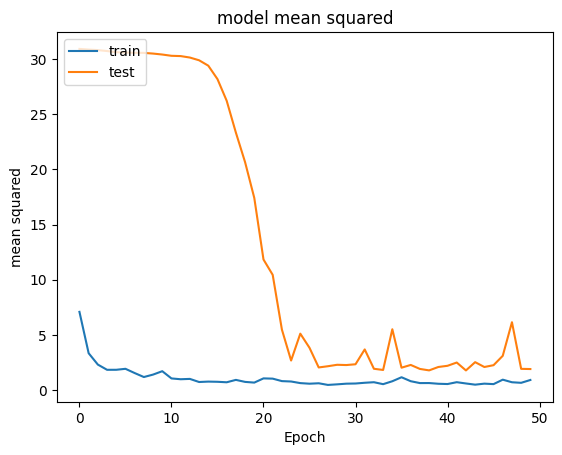

In [23]:
plt.plot(history.history['mae'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_mae'][display_epochs[0]:display_epochs[1]])
plt.title('model mean squared')
plt.ylabel('mean squared')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

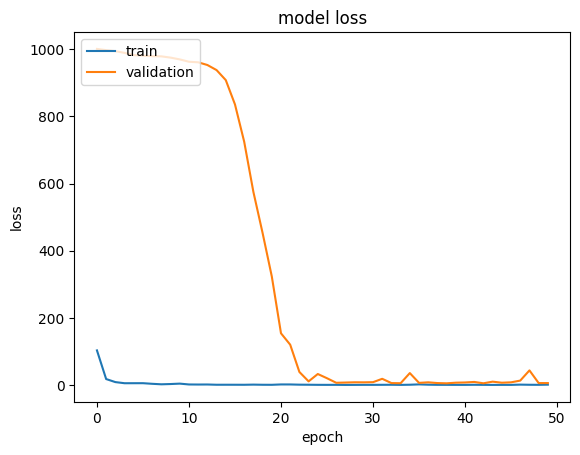

In [24]:
plt.plot(history.history['loss'][display_epochs[0]:display_epochs[1]])
plt.plot(history.history['val_loss'][display_epochs[0]:display_epochs[1]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Bibliografia

- Deep Learning with Python, Second Edition. François Chollet